# Retrosynthetically Decompose a Molecule In a Tree Structure Using Recap in RDKit--Update to Create Diagram Programmatically

This is an update of a blog post to programmatically draw the entire retrosynthetic diagram. 

[Retrosynthetic analysis](https://en.wikipedia.org/wiki/Retrosynthetic_analysis) involves decomposing a target molecule into a set of fragments that could be combined to make the parent molecule using common reactions. The [Recap algorithm](https://www.semanticscholar.org/paper/RECAP-%E2%80%94-Retrosynthetic-Combinatorial-Analysis-A-New-Lewell-Judd/fbfb10d1f63aa803f6d47df6587aa0e41109f5ee) by X. Lewell, D. Judd, S. Watson, and M. Hann accomplishes that. [Recap is implemented in the RDKit](https://www.rdkit.org/docs/GettingStartedInPython.html#recap-implementation) cheminformatics Python package.

*[Download this notebook from GitHub by right-clicking and choosing Save Link As...](https://raw.githubusercontent.com/bertiewooster/bertiewooster.github.io/main/_notebooks/2022-11-11-RDKit-Recap-decomposition-tree.ipynb)*

RDKit helpfully provides a `RecapHierarchyNode` structure of nodes, where the keys are SMILES strings corresponding to the fragment, and the values are nodes containing child fragments. However, it is not easy to visualize the results, because the results are SMILES strings and the hierarchy is not shown visually.

This utility function `molecule_recap_tree` allows you to visualize both the fragments and their hierarchy. Here is an example, of [6-(Hydroxymethoxy)pyridin-2-yl]oxymethanol, annotated to explain the hierarchy:

![annotated_hierarchy_tree](../images/tree_marked_up.png)

As compared to the same molecule using the `RecapDecompose` function directly, showing only the immediate children:

In [ ]:
from IPython.display import SVG
from rdkit import Chem
from rdkit.Chem import Draw, Recap
from rdkit import Geometry

['*CO', '*c1cccc(OCO)n1']

In [47]:
molecule = Chem.MolFromSmiles("n1c(OCO)cccc1-OCO")
hierarch = Recap.RecapDecompose(molecule)
ks=hierarch.children.keys()
sorted(ks)

['*CO', '*c1cccc(OCO)n1']

In [48]:
def concat_grids_horizontally(grid1:list[list[str]], grid2:list[list[str]]) -> list[list[str]]:
    """Concatenate two nested lists horizontally, for example
    inputs [['a'],['b'],['c']] and [['d'], ['e'], ['f']] 
    produce [['a', 'd'], ['b', 'e'], ['c', 'f']]

    :returns: The combined grid, a two-deep nested list of strings
    :param grid1: The first grid, a two-deep nested list of strings
    :param grid2: The second grid, a two-deep nested list of strings
    """
    if grid1 == [[]]:
        combined = grid2
    elif grid2 == [[]]:
        combined = grid1
    else:
        combined = []
        for row_counter in range(len(grid1)):
            combined += [grid1[row_counter] + grid2[row_counter]]
    return combined

class NonBinTree:
    """
    Nonbinary tree class
    Note that this class is not designed to sort nodes as they are added to the tree;
    the assumption is that they should be ordered in the order added
    Adapted from https://stackoverflow.com/questions/60579330/non-binary-tree-data-structure-in-python#60579464
    """

    def __init__(self, val:str):
        """Create a NonBinTree instance"""
        self.val = val
        self.nodes = []

    def add_node(self, val:str):
        """Add a node to the tree and return the new node"""
        self.nodes.append(NonBinTree(val))
        return self.nodes[-1]

    def __repr__(self) -> str:
        """Print out the tree as a nested list"""
        return f"NonBinTree({self.val}): {self.nodes}"

    def get_ncols(self) -> int:
        """Get the number of columns in the tree"""
        self.ncols = 0
        if len(self.nodes) > 0:
            # If there are nodes under this one, call get_ncols on them recursively
            for node in self.nodes:
                self.ncols += node.get_ncols()
        else:
            # If there are no nodes under this one, add 1 for this node
            self.ncols += 1
        return self.ncols

    def get_max_depth(self) -> int:
        """Get the maximum depth of the tree"""
        max_depth = 0
        if len(self.nodes) > 0:
            for node in self.nodes:
                this_depth = node.get_max_depth()
                max_depth = max(this_depth + 1, max_depth)
        else:
            max_depth = max(1, max_depth)
        self.max_depth = max_depth
        return self.max_depth

    def get_grid(self) -> list[list[str]]:
        """
        Get a two-dimensional grid where
        each row is a level in the fragment hierarchy, and
        the columns serve to arrange the fragments horizontally
        """
        # Call methods to calculate self.ncols and self.max_depth
        self.get_ncols()
        self.get_max_depth()

        # Create top row: Node value, then the rest of columns are blank (empty strings)
        grid = [[self.val] + [""] * (self.ncols - 1)]

        n_nodes = len(self.nodes)

        if n_nodes > 0:
            nodes_grid = [[]]

            # Iterate through the child nodes
            for node_counter, node in enumerate(self.nodes):
                # Recursively call this function to get the grid for children
                node_grid = node.get_grid()

                # Add spacer rows if needed
                node_grid_rows = len(node_grid)
                rows_padding = self.max_depth - node_grid_rows - 1
                for padding in range(rows_padding):
                    node_grid += [[""] * len(node_grid[0])]

                nodes_grid = concat_grids_horizontally(nodes_grid, node_grid)

            grid += nodes_grid

        return grid

In [49]:
def get_children(base_node:Chem.Recap.RecapHierarchyNode, root:NonBinTree = None) -> NonBinTree:
    """
    Convert an RDKit RecapHierarchyNode into a NonBinTree by
    traversing the RecapHierarchyNode, getting all its children recursively, and adding them to a NonBinTree

    :returns: NoBinTree containing the Recap hierarchy
    :param base_node: The RDKit RecapHierarchyNode
    :param root: The NoBinTree containing only the root node
    """
    for smiles, node in base_node.children.items():
        added_tree_node = root.add_node(smiles)
        children = node.children.keys()
        # Sort the children nodes to get consistent ordering
        children = sorted(children)
        if len(children) > 0:
            get_children(node, added_tree_node)
    return root

In [50]:
def molecule_recap_tree(smiles:str, name:str="", verbose=False, **kwargs):
    """
    Draw a molecular fragmentation tree using the Recap algorithm given in
    https://www.semanticscholar.org/paper/RECAP-%E2%80%94-Retrosynthetic-Combinatorial-Analysis-A-New-Lewell-Judd/fbfb10d1f63aa803f6d47df6587aa0e41109f5ee

    :returns: RDKit grid image, and (if verbose=True) RDKit molecule of parent molecule, Recap hierarchy, nonbinary tree hierarchy, and fragment grid
    :rtype: RDKit grid image, and (if verbose=True) rdkit.Chem.rdchem.Mol, rdkit.Chem.Recap.RecapHierarchyNode, NonBinTree, list[list[str]]
    :param smiles: The SMILES string of the molecule to be fragmented
    :param name: The name of the parent molecule; if not supplied, it will be labled with its SMILES string
    :param verbose: Whether to return verbose output; default is False so calling this function will present a grid image automatically
    """
    molecule = Chem.MolFromSmiles(smiles)
    RecapHierarchy = Recap.RecapDecompose(molecule)
    root = NonBinTree(RecapHierarchy.smiles)
    molecule_nonbinary_tree = get_children(RecapHierarchy, root)
    fragment_grid = molecule_nonbinary_tree.get_grid()
    # Add a blank element at the beginning of each row to make room for the left legend
    for row in fragment_grid:
        row.insert(0, "")
    print(f"Fragment grid: {fragment_grid}")
    mols_per_row = len(fragment_grid[0])
    recap_plot = [item for sublist in fragment_grid for item in sublist]
    print(f"Recap plot: {recap_plot}")
    recap_labels = [item for sublist in fragment_grid for item in sublist]
    if name:
        recap_labels[0] = name

    # Use MolsMatrixToGridImage if available in the installed version of RDKit
    molsMatrix = [[Chem.MolFromSmiles(smile) for smile in sublist] for sublist in fragment_grid]
    try:
        drawing = Draw.MolsMatrixToGridImage(molsMatrix=molsMatrix, legendsMatrix=fragment_grid, **kwargs)
    except AttributeError:
        drawing = Draw.MolsToGridImage([Chem.MolFromSmiles(smile) for smile in recap_plot], legends=recap_labels, molsPerRow=mols_per_row, **kwargs)
        
    if verbose:
        return drawing, molecule, RecapHierarchy, molecule_nonbinary_tree, fragment_grid, recap_plot
    else:
        return drawing

Here is the unannotated output:

In [51]:
drawing, molecule, RecapHierarchy, molecule_nonbinary_tree, fragment_grid, recap_plot = molecule_recap_tree("n1c(OCO)cccc1-OCO", "Parent molecule", verbose=True)

Fragment grid: [['', 'OCOc1cccc(OCO)n1', '', ''], ['', '*CO', '*c1cccc(OCO)n1', ''], ['', '', '*CO', '*c1cccc(*)n1']]
Recap plot: ['', 'OCOc1cccc(OCO)n1', '', '', '', '*CO', '*c1cccc(OCO)n1', '', '', '', '*CO', '*c1cccc(*)n1']


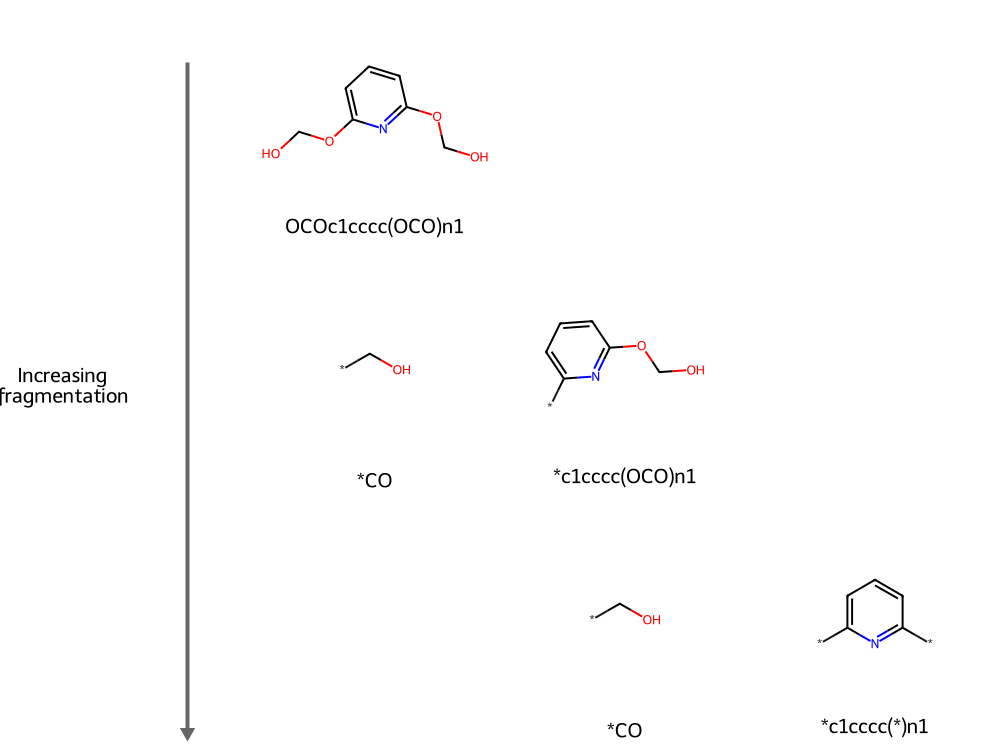

In [ ]:
# set up the drawing object:
nRows = 3
nCols = 4
panelx = 250
panely = 250
width = panelx * nCols
height = panely * nRows
d2d = Draw.MolDraw2DSVG(width, height, panelx, panely)
dopts = d2d.drawOptions()
dopts.legendFontSize = 20

recap_plot_mols = [Chem.MolFromSmiles(sml) for sml in recap_plot]

# draw the sidechains
d2d.DrawMolecules(
    recap_plot_mols,
    legends=recap_plot,
    )

# Now draw all the arrows and add the free-energy values
d2d.SetLineWidth(4)
font_size = 20
d2d.SetFontSize(font_size)

# use gray arrows so that they don't stand out quite so much
#   (the original figure has solid black, but I find this nicer)
arrowColor = (.4,.4,.4)

# Arrow for "Increasing Fragmentation"
p1 = Geometry.Point2D(panelx * 3/4,panely/4)
p2 = Geometry.Point2D(panelx * 3/4,height + panely/4)
d2d.DrawArrow(p1,p2,color=arrowColor,rawCoords=True, asPolygon=True, frac=0.01)

# Text "Increasing Fragmentation"
midp = Geometry.Point2D()
midp.x = panelx * 1/4
midp.y = height/2
d2d.DrawString("Increasing", midp, rawCoords=True)
midp.y += font_size
d2d.DrawString("fragmentation", midp, rawCoords=True)

d2d.FinishDrawing()
svg = d2d.GetDrawingText()
SVG(svg)

Stars ("dummy atoms") show points where the molecule was fragmented.

The key RDKit commands that `molecule_recap_tree` uses are:
- [`RecapDecompose`](https://www.rdkit.org/docs/GettingStartedInPython.html#recap-implementation) to decompose the parent molecule into successive fragments
- [`MolsToGridImage`](https://www.rdkit.org/docs/source/rdkit.Chem.Draw.html#rdkit.Chem.Draw.MolsToGridImage) to draw the fragment hierarchy in a grid, and label the fragments with their SMILES strings

## Get Additional Data
If you want `molecule_recap_tree` to return not just the grid image, but also the parent molecule, the RDKit Recap hiearchy node, the non-binary tree hierarchy, and grid of fragment hierarchy, set `verbose=True`:

In [ ]:
drawing, molecule, RecapHierarchy, molecule_nonbinary_tree, fragment_grid = molecule_recap_tree("n1c(OCO)cccc1-OCO", "Parent molecule", verbose=True)

Fragment grid: [['', 'OCOc1cccc(OCO)n1', '', ''], ['', '*CO', '*c1cccc(OCO)n1', ''], ['', '', '*CO', '*c1cccc(*)n1']]
Recap plot: ['', 'OCOc1cccc(OCO)n1', '', '', '', '*CO', '*c1cccc(OCO)n1', '', '', '', '*CO', '*c1cccc(*)n1']


You then must explicitly call the hierarchy image to draw it:

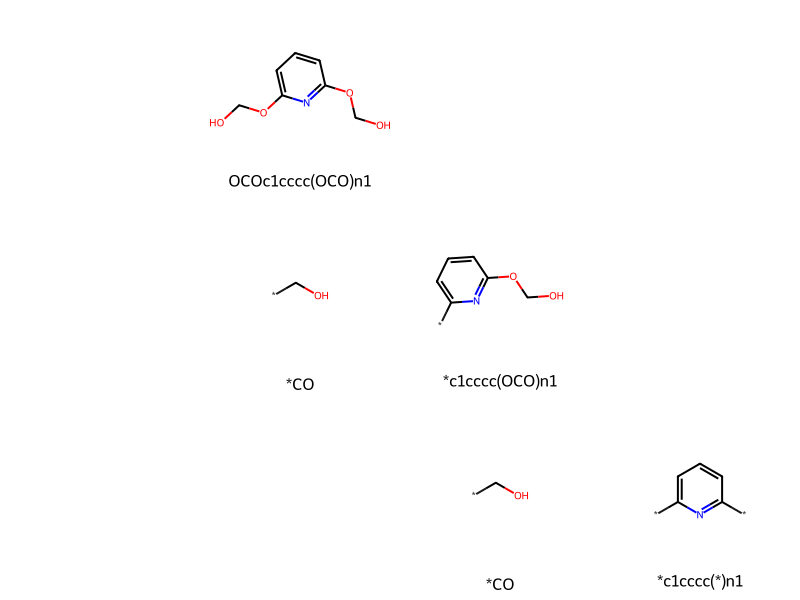

In [ ]:
drawing

`molecule` is the RDKit parent molecule:

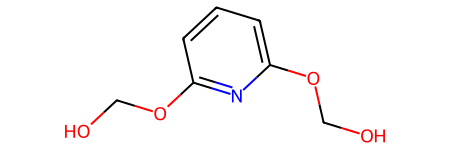

In [ ]:
molecule

`RecapHierarchy` is the RDKit Recap hierarchy, which returns the top-level node, which you could traverse to obtain the hierarchy:

In [ ]:
RecapHierarchy

`molecule_nonbinary_tree` is the NonBinTree hierarchy, which contains the same hierarchy as the `RecapHierarchy`, and gives all the nodes directly:

In [ ]:
molecule_nonbinary_tree

NonBinTree(OCOc1cccc(OCO)n1): [NonBinTree(*CO): [], NonBinTree(*c1cccc(OCO)n1): [NonBinTree(*CO): [], NonBinTree(*c1cccc(*)n1): []]]

`fragment_grid` is the two-dimensional fragment grid, where each row is a level in the fragment hierarchy, and the columns serve to arrange the fragments horizontally:

In [ ]:
fragment_grid

[['', 'OCOc1cccc(OCO)n1', '', ''],
 ['', '*CO', '*c1cccc(OCO)n1', ''],
 ['', '', '*CO', '*c1cccc(*)n1']]

Or, more nicely formatted into columns and with empty strings not shown:

In [ ]:
for smiles1, smiles2, smiles3 in fragment_grid:
    print (f"{smiles1:^20}{smiles2:^20}{smiles3:^20}")

ValueError: too many values to unpack (expected 3)

## Pass Arguments to MolsToGridImage

More complex molecules can easily produce many fragments:

Fragment grid: [['COc1cc(N)c(Cl)cc1C(=O)NC1CCN(CCCOc2ccc(F)cc2)CC1OC', '', '', '', '', '', '', '', '', '', ''], ['*C(=O)c1cc(Cl)c(N)cc1OC', '*NC1CCN(CCCOc2ccc(F)cc2)CC1OC', '', '', '', '*CCCOc1ccc(F)cc1', '*N1CCC(NC(=O)c2cc(Cl)c(N)cc2OC)C(OC)C1', '', '*c1ccc(F)cc1', '*CCCN1CCC(NC(=O)c2cc(Cl)c(N)cc2OC)C(OC)C1', ''], ['', '*NC1CCN(*)CC1OC', '*CCCOc1ccc(F)cc1', '*c1ccc(F)cc1', '*CCCN1CCC(N*)C(OC)C1', '', '*NC1CCN(*)CC1OC', '*C(=O)c1cc(Cl)c(N)cc1OC', '', '*C(=O)c1cc(Cl)c(N)cc1OC', '*CCCN1CCC(N*)C(OC)C1']]
Recap plot: ['COc1cc(N)c(Cl)cc1C(=O)NC1CCN(CCCOc2ccc(F)cc2)CC1OC', '', '', '', '', '', '', '', '', '', '', '*C(=O)c1cc(Cl)c(N)cc1OC', '*NC1CCN(CCCOc2ccc(F)cc2)CC1OC', '', '', '', '*CCCOc1ccc(F)cc1', '*N1CCC(NC(=O)c2cc(Cl)c(N)cc2OC)C(OC)C1', '', '*c1ccc(F)cc1', '*CCCN1CCC(NC(=O)c2cc(Cl)c(N)cc2OC)C(OC)C1', '', '', '*NC1CCN(*)CC1OC', '*CCCOc1ccc(F)cc1', '*c1ccc(F)cc1', '*CCCN1CCC(N*)C(OC)C1', '', '*NC1CCN(*)CC1OC', '*C(=O)c1cc(Cl)c(N)cc1OC', '', '*C(=O)c1cc(Cl)c(N)cc1OC', '*CCCN1CCC(N*)C(OC)

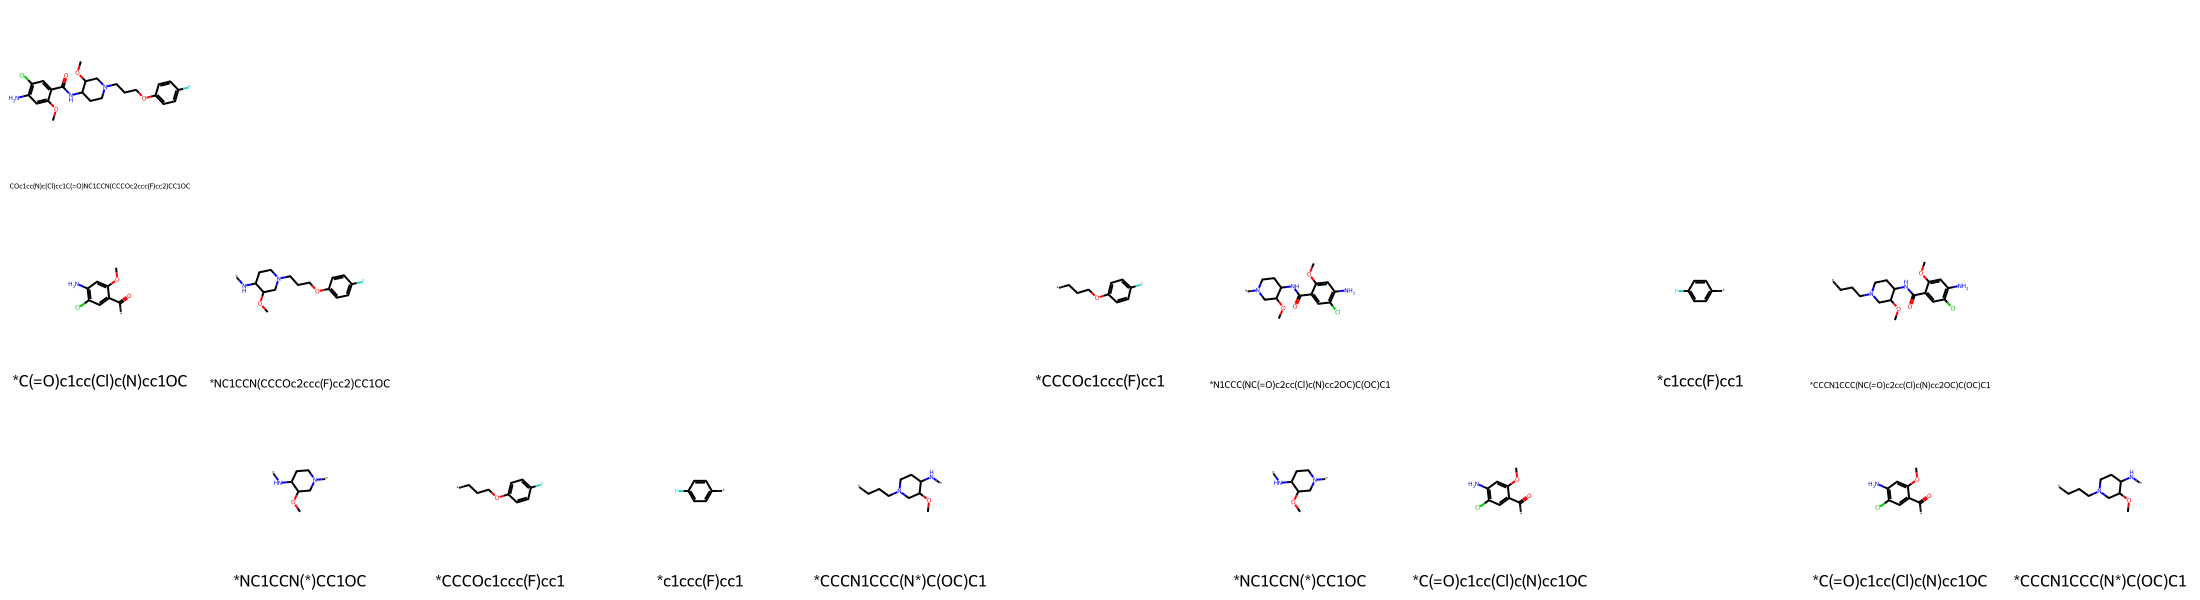

In [ ]:
molecule_recap_tree("Clc1cc(c(OC)cc1N)C(=O)NC3CCN(CCCOc2ccc(F)cc2)CC3OC", "parent molecule")

If you zoom into a fragment, you will notice that it is fuzzy due to the low resolution.

To address this case, you can use `molecule_recap_tree`'s ability to pass any keyword arguments of [`Draw.MolsToGridImage`](https://www.rdkit.org/docs/source/rdkit.Chem.Draw.html?highlight=molstogridimage#rdkit.Chem.Draw.MolsToGridImage) to that function. Specifically, you can pass the `useSVG=True` flag so that the molecular images do not lose resolution when you zoom into them. If you zoom into this image, you will notice that the fragments are easy to read because [Scalable Vector Graphics](https://en.wikipedia.org/wiki/Scalable_Vector_Graphics) is, as the name states, a vector format. (`useSVG=True` is not the default in `molecule_recap_tree` because bonds are not nicely joined as they are in the default PNG format.)

Fragment grid: [['COc1cc(N)c(Cl)cc1C(=O)NC1CCN(CCCOc2ccc(F)cc2)CC1OC', '', '', '', '', '', '', '', '', '', ''], ['*C(=O)c1cc(Cl)c(N)cc1OC', '*NC1CCN(CCCOc2ccc(F)cc2)CC1OC', '', '', '', '*CCCOc1ccc(F)cc1', '*N1CCC(NC(=O)c2cc(Cl)c(N)cc2OC)C(OC)C1', '', '*c1ccc(F)cc1', '*CCCN1CCC(NC(=O)c2cc(Cl)c(N)cc2OC)C(OC)C1', ''], ['', '*NC1CCN(*)CC1OC', '*CCCOc1ccc(F)cc1', '*c1ccc(F)cc1', '*CCCN1CCC(N*)C(OC)C1', '', '*NC1CCN(*)CC1OC', '*C(=O)c1cc(Cl)c(N)cc1OC', '', '*C(=O)c1cc(Cl)c(N)cc1OC', '*CCCN1CCC(N*)C(OC)C1']]
Recap plot: ['COc1cc(N)c(Cl)cc1C(=O)NC1CCN(CCCOc2ccc(F)cc2)CC1OC', '', '', '', '', '', '', '', '', '', '', '*C(=O)c1cc(Cl)c(N)cc1OC', '*NC1CCN(CCCOc2ccc(F)cc2)CC1OC', '', '', '', '*CCCOc1ccc(F)cc1', '*N1CCC(NC(=O)c2cc(Cl)c(N)cc2OC)C(OC)C1', '', '*c1ccc(F)cc1', '*CCCN1CCC(NC(=O)c2cc(Cl)c(N)cc2OC)C(OC)C1', '', '', '*NC1CCN(*)CC1OC', '*CCCOc1ccc(F)cc1', '*c1ccc(F)cc1', '*CCCN1CCC(N*)C(OC)C1', '', '*NC1CCN(*)CC1OC', '*C(=O)c1cc(Cl)c(N)cc1OC', '', '*C(=O)c1cc(Cl)c(N)cc1OC', '*CCCN1CCC(N*)C(OC)

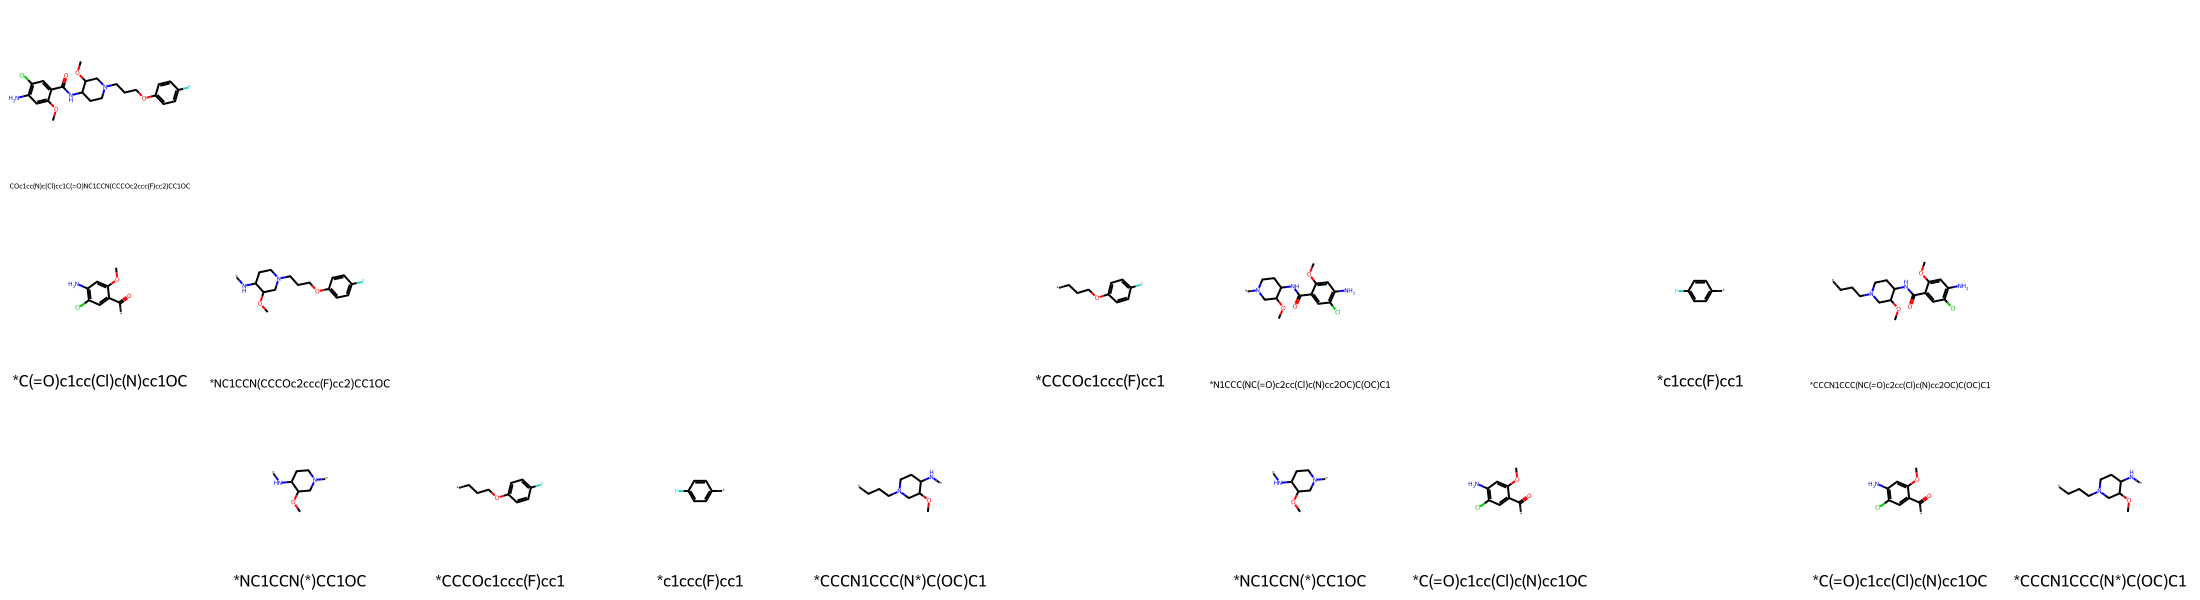

In [ ]:
molecule_recap_tree("Clc1cc(c(OC)cc1N)C(=O)NC3CCN(CCCOc2ccc(F)cc2)CC3OC", "parent molecule", useSVG=True)

## Note About Hierarchies
Another approach I could have taken was to extend the class `rdkit.Chem.Recap.RecapHierarchyNode`, rather than use the `NonBinaryTree` class. Using the `NonBinaryTree` class allows for different kinds of hierarchies to be depicted as a grid, as I demonstrate in other posts [Visualizing Nonbinary Trees: Classification of Chemical Isomers]({% post_url 2022-12-18-Visualizing-Nonbinary-Trees-Classification-of-Chemical-Isomers %}) and [Draw a Mass Spectrometry Fragmentation Tree Using RDKit]({% post_url 2023-01-02-Mass-Spectrometry-Fragmentation-Tree %}).